## A map of tweets before and after the invasion of Ukraine 

In this notebook, we analyze and create a map of tweets before and after the invasion of Ukraine. 

The data was scraped via the twitter-scraper notebook that you can find in the same github folder as this one. The data was scraped as follows: 
- All Tweets from the day before the invasion of Ukraine and the 3 days after were scraped (Feb. 23 - Feb. 26, 2022)
- All tweets from another period of the same duration were scraped for comparison (ec. Dec. 01 - Dec. 04, 2021)

The data we scraped contains some information about the users, such as their location, which is the only relevant information for this notebook. Since the scraped location is **a string**, we had to use Geopy to convert it to latitude and longitude to generate some interesting plots.

Unfortunately, Geopy comes with its limitations, and the free APIs like Nominatim only allow for about **1 request per second**. This makes fetching all of our tweets **unfeasible**: 44602 and 4939017 observations would take about **12 hours** and **57 days** respectively. 

For this reason, I am going to randomly sample 1 observations every 30. This brings the numbers down to 1.5k (4 hours) and 164k (a little less than 2 days). 

-----
## Section 1: Data processing 
This first part takes A LOT of time to run, mostly because we have to query all of the locations from the User column. At the end of this phase, the data is saved so that we can just start our analysis from section 2.

In [1]:
import pandas as pd
import datetime 
import geopandas as gpd 
import matplotlib.pyplot as plt 
from shapely.geometry import Point
import geoplot 

In [62]:
data_before = pd.read_csv(r'data\ukr_tweets_dec01_dec04_2021.csv', sep = '~', 
                          index_col=0, usecols = [0,1,2,3] )

data_after = pd.read_csv(r'data\ukr_tweets_feb23_feb26_2022.csv', sep = '~', 
                          index_col=0, usecols = [0,1,2,3] )

,index,date,content
0,28302,2021-12-03 19:48:03+00:00,"With regard to geopolitics, ""A Pokamon Trainer..."
4,40387,2021-12-04 18:07:41+00:00,"More seriously, I think if Putin is going to i..."
5,13023,2021-12-02 10:24:35+00:00,"@McFaul Rubbish, the #US backed a coup in #Ukr..."
6,321,2021-12-01 01:24:59+00:00,@NickAdamsinUSA They might...might...get away ...
7,32496,2021-12-04 04:38:03+00:00,@Lucian_Kim @IlvesToomas Ukraine's greatest fo...


In [ ]:
data_before.head()

In [14]:
print(len(data_before), len(data_after))

44602 4939017


In [15]:
data_before = data_before.sample(n=len(data_before)//30, replace = False,random_state=1)
data_after = data_after.sample(n=len(data_after)//30, replace = False, random_state=1)

data_before.reset_index(inplace=True)
data_after.reset_index(inplace=True)

In [16]:
print(len(data_before), len(data_after))

1486 164633


In [17]:
#easiest way i could think of, since 'user' column was read as string..
loc_before = [eval(data_before['user'].iloc[i])['location'] for i in data_before.index]
loc_after = [eval(data_after['user'].iloc[i])['location'] for i in data_after.index]

In [18]:
data_after['loc'] = loc_after
data_before['loc'] = loc_before

In [19]:
data_before.head()

,index,date,content,user,loc
0,28302,2021-12-03 19:48:03+00:00,"With regard to geopolitics, ""A Pokamon Trainer...","{'username': 'Ukrainianism', 'id': 12960319577...",Rocky Mountain Steppe
1,42341,2021-12-04 20:30:00+00:00,"Russia planning 175,000-troops offensive again...","{'username': 'yenisafakEN', 'id': 793388868, '...",
2,5490,2021-12-01 15:19:00+00:00,RT @NATOpress: #NATO’s support for #Georgia &a...,"{'username': 'Twheater2', 'id': 10029189655495...",
3,6230,2021-12-01 16:25:11+00:00,@Andrew_ded @GAZDEP_UA @SergejTalk В провинции...,"{'username': 'rfOC9fRqeBjLaE1', 'id': 14073874...",
4,40387,2021-12-04 18:07:41+00:00,"More seriously, I think if Putin is going to i...","{'username': 'zagrebista', 'id': 41578178, 'di...",Caledonia


In [20]:
#remove empty location values
data_after = data_after[data_after['loc'] != ''].copy()
data_before = data_before[data_before['loc'] != ''].copy()

In [21]:
#extract coordinates with geopy 
from geopy.geocoders import Nominatim
import geopy as gp

geolocator = Nominatim(user_agent="xpiri")

WARNING: the following cell takes about 2 days to run!

In [ ]:
def coordinate_extractor(df): 
    ls = []
    for ind,dat in df.iterrows():            
        try: 
            g = geolocator.geocode(dat['loc'])
            print(ind)
            if g:
                ls.append((ind, g.latitude, g.longitude))
        except: 
            print(ind, dat['loc'])
            pass
    return ls 

ls_before = coordinate_extractor(data_before)
ls_after = coordinate_extractor(data_after)

In [37]:
coords_bef = pd.DataFrame(ls_before, columns = ['index','latitude','longitude'])
coords_bef.set_index('index', inplace=True)

coords_after = pd.DataFrame(ls_after, columns = ['index','latitude','longitude'])
coords_after.set_index('index', inplace=True)

In [42]:
data_before = data_before.join(coords_bef)
data_after = data_after.join(coords_after)

In [43]:
data_before.to_csv(r'data\ukr_tweets_dec01_dec04_2021_with_locs.csv', sep = '~')
data_after.to_csv(r'data\ukr_tweets_feb23_feb26_2022_with_locs.csv', sep = '~')

## Section 2: data visualization
The previous section served as a checkpoint for the following one, which is the interesting part. We're gonna be plotting the map of tweets mentioning Ukraine using both scatterplots and kernel density estimate plots. 

NOTE: I am fully aware that the scraped data will mostly be in english since I only used "Ukraine" as my query, thus ignoring pretty much all other languages. However, I still believe that the representation that we get is quite interesting and highlights how many people reacted to the Russian invasion of Ukraine.

In [222]:
import warnings
warnings.filterwarnings('ignore') #suppress geopandas warnings about crs

data_before = pd.read_csv(r'data\ukr_tweets_dec01_dec04_2021_with_locs.csv', sep = '~', 
                          index_col=0)
data_before['Coordinates'] = list(zip(data_before.longitude, data_before.latitude))

data_after = pd.read_csv(r'data\ukr_tweets_feb23_feb26_2022_with_locs.csv', sep = '~', 
                          index_col=0)

data_after['Coordinates'] = list(zip(data_after.longitude, data_after.latitude))

In [223]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))

data_before['Coordinates'] = data_before['Coordinates'].apply(Point)
data_before_gpd = gpd.GeoDataFrame(data_before, geometry = 'Coordinates')
data_after['Coordinates'] = data_after['Coordinates'].apply(Point)
data_aft_gpd = gpd.GeoDataFrame(data_after, geometry = 'Coordinates')

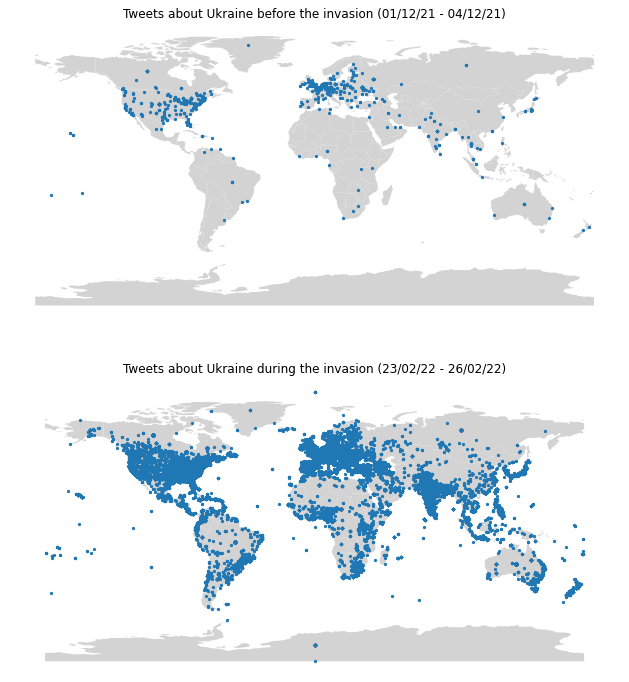

In [281]:
fig, ax = plt.subplots(2,1, figsize = (12,12))

countries.plot(color="lightgrey", ax = ax[0])
data_before_gpd.plot(ax = ax[0], markersize = 5)
ax[0].set_title('Tweets about Ukraine before the invasion (01/12/21 - 04/12/21)')
ax[0].axis('off')

countries.plot(color="lightgrey", ax = ax[1])
data_aft_gpd.plot(ax = ax[1], markersize = 5)
ax[1].set_title('Tweets about Ukraine during the invasion (23/02/22 - 26/02/22)')
ax[1].axis('off')
plt.show()

In [225]:
#before joining, adding a kind (before and after) column to highlight the different points 
data_before_gpd_filt['kind'] = 'before'
data_aft_gpd_filt['kind'] = 'after'

In [226]:
joined = gpd.GeoDataFrame( pd.concat( [data_aft_gpd_filt, data_before_gpd_filt], ignore_index=True) )

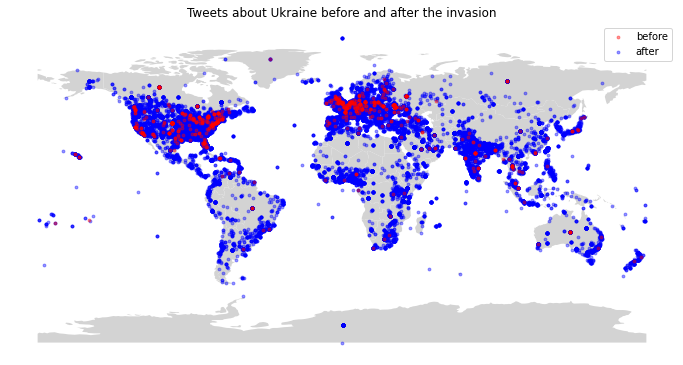

In [271]:
fig,ax = plt.subplots(1,1,figsize = (12,15))

countries.plot(color="lightgrey", ax = ax)
joined.loc[joined['kind']=='after'].plot(ax = ax, alpha = .4, color = 'b', label='after', markersize = 8)
joined.loc[joined['kind']=='before'].plot(ax = ax, alpha = .4, color = 'r', label='before', markersize = 8)
ax.set_title('Tweets about Ukraine before and after the invasion')

#fix the order in which the legend elements appear (before is appearing 2nd, after is appearning 1st)
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.axis('off')
plt.show()

In [228]:
data_aft_joined = data_aft_gpd_filt.sjoin(countries, how="inner", predicate='intersects')
data_bef_joined = data_before_gpd_filt.sjoin(countries, how="inner", predicate='intersects')

In [229]:
data_bef_countries = gpd.GeoDataFrame(data_bef_joined.groupby('name').size(), columns = ['count'])
data_bef_countries.reset_index(inplace = True)
data_bef_countries = data_bef_countries.merge(countries[['name','geometry']], how = 'inner', left_on = 'name', right_on = 'name')

data_aft_countries = gpd.GeoDataFrame(data_aft_joined.groupby('name').size(), columns = ['count'])
data_aft_countries.reset_index(inplace = True)
data_aft_countries = data_aft_countries.merge(countries[['name','geometry']], how = 'inner', left_on = 'name', right_on = 'name')

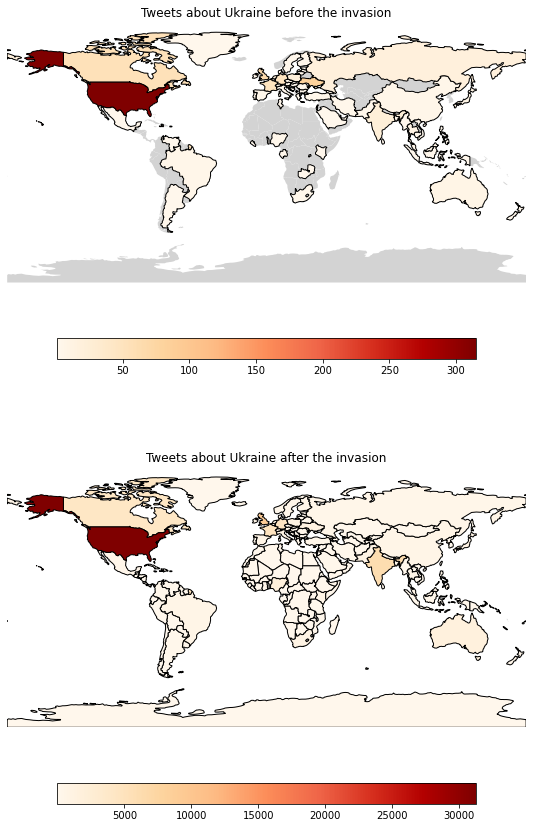

In [231]:
fig,ax = plt.subplots(2,1,figsize = (15,15), 
                        sharex=True, sharey=True)

boundaries = range(0, max(data_bef_countries['count'].max(),data_aft_countries['count'].max()), max(data_bef_countries['count'].max(),data_aft_countries['count'].max())//10)

countries.plot(color="lightgrey", ax = ax[0])
geoplot.choropleth(data_bef_countries, hue='count', cmap='OrRd', legend=True, ax = ax[0],
                   legend_kwargs={'orientation': 'horizontal', 'shrink' : .5})
ax[0].set_title('Tweets about Ukraine before the invasion')

countries.plot(color="lightgrey", ax = ax[1])
geoplot.choropleth(data_aft_countries, hue='count', cmap='OrRd', legend=True, ax = ax[1], 
                   legend_kwargs={'orientation': 'horizontal', 'shrink' : .5})
ax[1].set_title('Tweets about Ukraine after the invasion')
plt.show()